In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

- Expected fantasy points based on individual stats (excluding yds, tds, rec, fumbles...)
- Maybe have rushing fantasy points, receiving fantasy points, and passing fantasy points instead of one big fantasy points feature
- Real fantasy points
- Expected fantasy points based on opportunity and team offense success
- Athletic score based on combine stats (momentum and distance)
- Draft pick feature
- Clustering feature that describes career performance (make a new table that is the yearly performance of a player and then use a cluster analysis to characterize different patterns like Rookie or Washed)
- try to make a "competition" df that finds/groups players by teams and sums targets/rushes of other players on the team. the only problem would be when a player played on two teams that year.
- make large dfs that can then be fed into a MLP to summarize the dfs for consistency, then compile them and further analyze for predictability

In [15]:
# Load data
gross_passing = pd.read_csv('gross_pfr_passing.csv')
gross_rushing = pd.read_csv('gross_pfr_rushing.csv')
gross_receiving = pd.read_csv('gross_pfr_receiving.csv')
gross_team_offense = pd.read_csv('gross_pfr_team_offense.csv')
gross_combine = pd.read_csv('gross_pfr_combine.csv')

# Transform Data

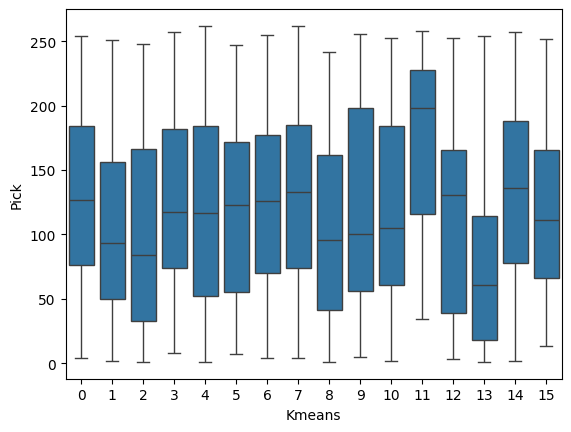

In [17]:
# Athletic Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for position
combine_clustering = gross_combine.copy()

# Filter for position
combine_clustering = combine_clustering[combine_clustering['Pos'].isin(['QB', 'RB', 'WR', 'TE', 'FB'])]

# Save Pick column to df
df = combine_clustering[['Pick', 'Pos', 'Player']]

# Select columns for clustering
combine_clustering = combine_clustering[['Wt', 'Height', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']]

# Convert categorical data to numeric
combine_clustering = combine_clustering.apply(pd.to_numeric, errors='coerce')

# Replace NaN with -1
combine_clustering.fillna(-1, inplace=True)

# Standardize the data
scaler = StandardScaler()
combine_clustering_scaled = scaler.fit_transform(combine_clustering)

# Kmeans
n_percent = int(combine_clustering.shape[0] * 0.05)
kmeans = KMeans(n_clusters=16, n_init=n_percent)
kmeans.fit(combine_clustering_scaled)
combine_clustering['Combine_Kmeans'] = kmeans.labels_

# Add Pick column back to df
combine_clustering = pd.concat([combine_clustering, df], axis=1)

# Plot clusters against Pick
sns.boxplot(x='Combine_Kmeans', y='Pick', data=combine_clustering)
plt.show()

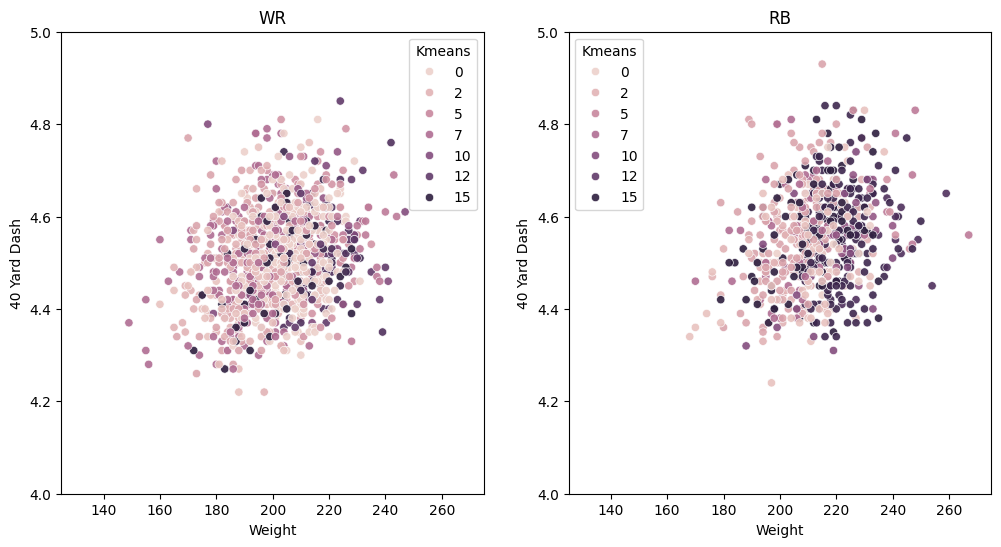

In [18]:
# Plot weight against 40yd
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('WR')
sns.scatterplot(x='Wt', y='40yd', hue='Kmeans', data=combine_clustering[combine_clustering["Pos"] == 'WR'], alpha=0.9)
plt.xlabel('Weight')
plt.ylabel('40 Yard Dash')
plt.xlim(125, 275)
plt.ylim(4, 5)

plt.subplot(1, 2, 2)
plt.title('RB')
sns.scatterplot(x='Wt', y='40yd', hue='Kmeans', data=combine_clustering[combine_clustering["Pos"] == 'RB'], alpha=0.9)
plt.xlabel('Weight')
plt.ylabel('40 Yard Dash')
plt.xlim(125, 275)
plt.ylim(4, 5)

plt.show()

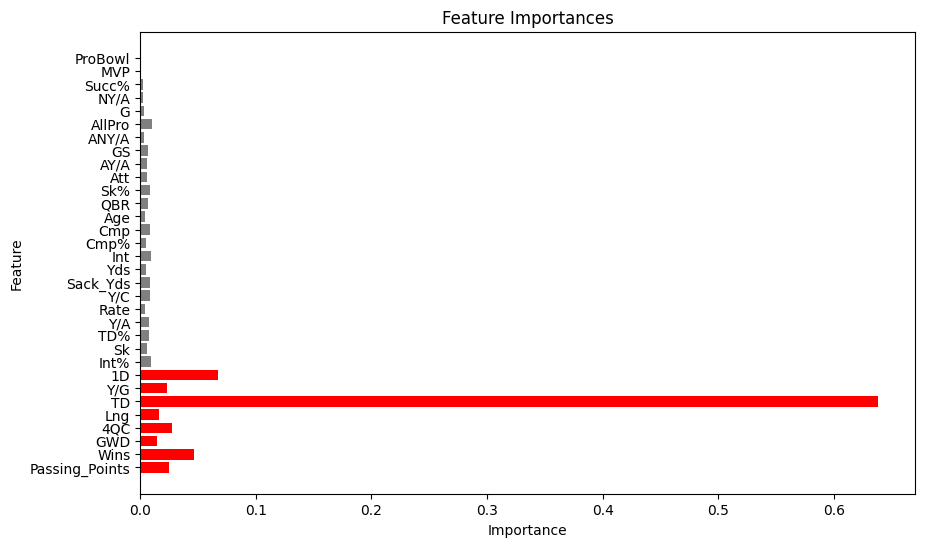

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import pandas as pd

# Save player, passing_points, and year columns to future
future = gross_passing[['Player', 'Passing_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Passing_Points': 'Future_Passing_Points'})

# Merge future with gross_passing on Player and Year
gross_passing = pd.merge(gross_passing, future, on=['Player', 'Year'], how='left')

# Load data
gross_passing = gross_passing.dropna(subset=['Future_Passing_Points']).reset_index(drop=True)
gross_passing = gross_passing.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Passing_Points']
X = gross_passing.drop(columns=columns_to_drop)
y = gross_passing['Future_Passing_Points']

def feature_selection(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Initialize the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

    # Initialize RFE with the model
    rfe = RFE(estimator=model, n_features_to_select=0.25, step=1)

    # Fit RFE
    rfe.fit(X_train, y_train)

    # Get the ranking of features
    ranking = rfe.ranking_

    # Get the support (selected features)
    support = rfe.support_

    # Fit the model on the entire training data to get feature importances
    model.fit(X_train, y_train)

    # Get the feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame to display the results
    feature_ranking_df = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': ranking,
        'Selected': support,
        'Importance': feature_importances
    })

    # Sort the DataFrame by ranking
    feature_ranking_df = feature_ranking_df.sort_values(by='Ranking')

    return feature_ranking_df

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

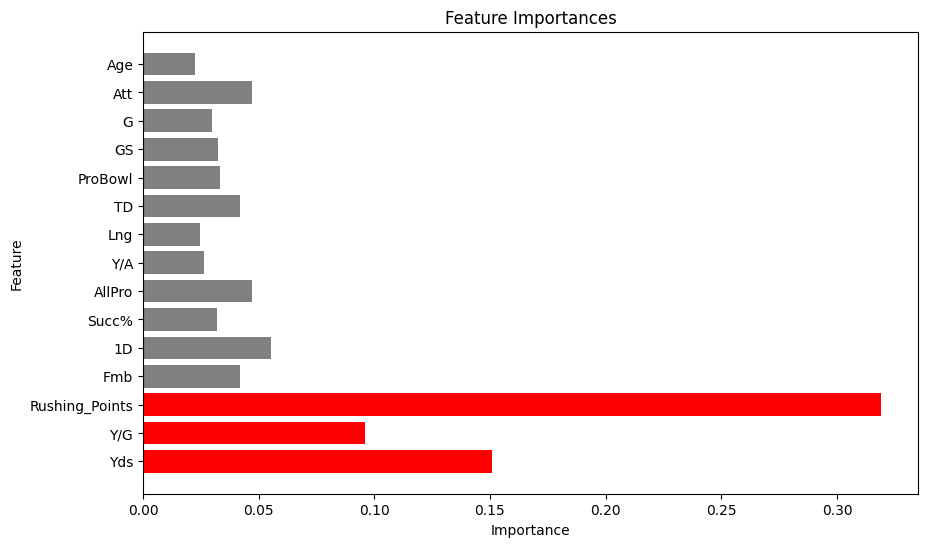

In [14]:
# Rushing Points Subset Selection
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Save player, rushing_points, and year columns to future
future = gross_rushing[['Player', 'Rushing_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Rushing_Points': 'Future_Rushing_Points'})

# Merge future with gross_rushing on Player and Year
gross_rushing = pd.merge(gross_rushing, future, on=['Player', 'Year'], how='left')

# Vectors to store R^2 and MAE
r_squared_scores = []
mae_scores = []

# Load data
gross_rushing = gross_rushing.dropna(subset=['Future_Rushing_Points']).reset_index(drop=True)
gross_rushing = gross_rushing.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Rushing_Points', 'Player-additional']
X = gross_rushing.drop(columns=columns_to_drop)

y = gross_rushing['Future_Rushing_Points']

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

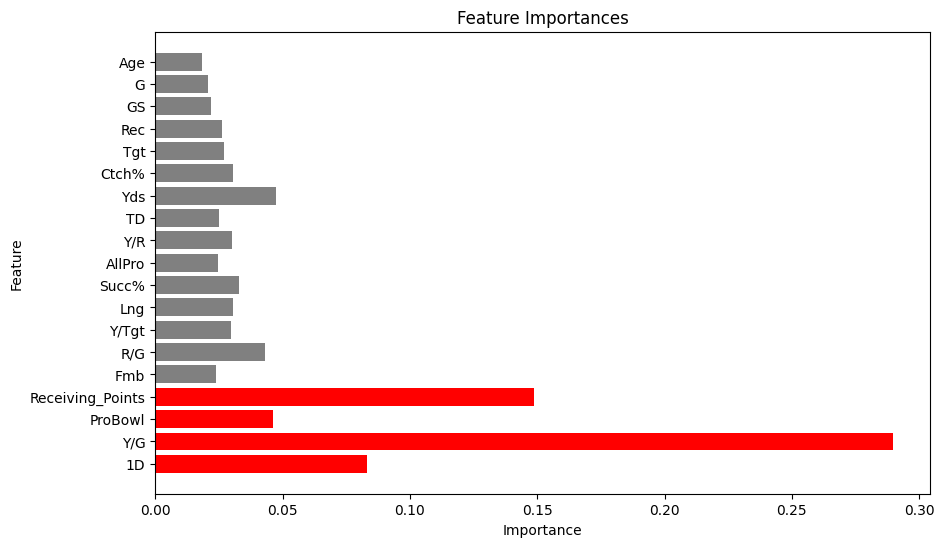

In [16]:
# Receiving Points Subset Selection
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Save player, receiving_points, and year columns to future
future = gross_receiving[['Player', 'Receiving_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Receiving_Points': 'Future_Receiving_Points'})

# Merge future with gross_receiving on Player and Year
gross_receiving = pd.merge(gross_receiving, future, on=['Player', 'Year'], how='left')

# Vectors to store R^2 and MAE
r_squared_scores = []
mae_scores = []

# Load data
gross_receiving = gross_receiving.dropna(subset=['Future_Receiving_Points']).reset_index(drop=True)
gross_receiving = gross_receiving.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Receiving_Points', 'Player-additional']
X = gross_receiving.drop(columns=columns_to_drop)
y = gross_receiving['Future_Receiving_Points']

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [10]:
# Career Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def career_averaging(df, target_column):
    # Prepare the data
    df = df[['Player', target_column, 'Year']]

    # Aggregate data to ensure unique Player-Year combinations
    df = df.groupby(['Player', 'Year']).agg({target_column: 'mean'}).reset_index()

    # Pivot the data on Year
    df_pivot = df.pivot(index='Player', columns='Year', values=target_column).reset_index()

    # Save players
    players = df_pivot['Player']
    df_pivot = df_pivot.drop(columns=['Player'])

    # For every column, average the current year and the previous years
    player_career = pd.DataFrame()
    for i in range(1, df_pivot.shape[1] + 1):
        player_career[i] = df_pivot.iloc[:, :i].mean(axis=1)

    # Rename each column to the year
    first_year_column = df_pivot.columns[0]
    player_career.columns = [str(i) for i in range(first_year_column+1, first_year_column + df_pivot.shape[1]+1)]
    player_career['Player'] = players

    # Melth the data
    player_career = player_career.melt(id_vars='Player', var_name='Year', value_name=target_column)

    # Convert Year to numeric
    player_career['Year'] = player_career['Year'].astype(int)

    # Add 'Career_' to the target column
    player_career = player_career.rename(columns={target_column: 'Career_' + target_column})

    return player_career

passing_career = career_averaging(gross_passing, 'Passing_Points')
rushing_career = career_averaging(gross_rushing, 'Rushing_Points')
receiving_career = career_averaging(gross_receiving, 'Receiving_Points')

receiving_career.head()

,Player,Year,Career_Receiving_Points
0,A.J. Brown,2013,NaN
1,A.J. Derby,2013,NaN
2,A.J. Green,2013,249.5
3,AJ Dillon,2013,NaN
4,Aaron Dobson,2013,NaN


In [18]:
# PCA Function
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
gross_passing = pd.read_csv('gross_pfr_passing.csv')

def pca_reduction(data, columns_to_drop = ['Player', 'Tm', 'Pos', 'Year'], suffix=''):
    # Initialize the PCA
    pca = PCA()
    scaler = StandardScaler()

    # Select columns for PCA
    X = data.drop(columns=columns_to_drop)
    X = X.fillna(-1)
    X_scaled = scaler.fit_transform(X)

    # Fit the PCA
    pca.fit(X_scaled)

    # Choose the top components that explain 85% of the variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()
    n_components = len(cumulative_explained_variance_ratio[cumulative_explained_variance_ratio <= 0.85])

    # Fit the PCA with the top components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for the PCA
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df = pca_df.add_suffix(suffix)
    pca_df = pd.concat([data[columns_to_drop], pca_df], axis=1)

    return pca_df

# Apply PCA
passing_pca = pca_reduction(gross_passing, suffix='_Passing')
rushing_pca = pca_reduction(gross_rushing, suffix='_Rushing')
receiving_pca = pca_reduction(gross_receiving, suffix='_Receiving')
teams_pca = pca_reduction(gross_team_offense, suffix='_Team_Offense', columns_to_drop=['Tm', 'Year', 'Team_Name'])
combine_pca = pca_reduction(gross_combine, suffix='_Combine', columns_to_drop=['Player', 'Pos', 'School', 'Team_Name', 'Round', 'Year', 'Tm'])

In [19]:
combine_pca.head()

,Player,Pos,School,Team_Name,Round,Year,Tm,PC1_Combine,PC2_Combine,PC3_Combine,PC4_Combine
0,John Abraham,OLB,South Carolina,New York Jets,1st,2000.0,NYJ,-2.585005,1.689679,-0.872466,-0.961322
1,Shaun Alexander,RB,Alabama,Seattle Seahawks,1st,2000.0,SEA,-2.976111,0.644293,-0.618396,-0.631678
2,Darnell Alford,OT,Boston Col.,Kansas City Chiefs,6th,2000.0,KAN,2.155703,1.526452,1.105292,0.122676
3,Kyle Allamon,TE,Texas Tech,NaN,NaN,NaN,NaN,0.865431,-0.440449,-1.251929,-1.078182
4,Rashard Anderson,CB,Jackson State,Carolina Panthers,1st,2000.0,CAR,0.840278,-1.148584,-0.855157,-1.112410


In [43]:
def ml_creation(gross, tartget_column):
    # Merge passing_career, rushing_career, and receiving_career
    gross = pd.merge(gross, passing_career, on=['Player', 'Year'], how='outer')
    gross = pd.merge(gross, rushing_career, on=['Player', 'Year'], how='outer')
    gross = pd.merge(gross, receiving_career, on=['Player', 'Year'], how='outer')

    # Merge career with gross_combine on Player
    gross = pd.merge(gross, combine_clustering[['Player', 'Pick', 'Kmeans']], on='Player', how='inner')

    # Merge gross with gross_team_offense on Tm and Year
    gross = pd.merge(gross, gross_team_offense, on=['Tm', 'Year'], how='inner')

    # Drop rows
    gross = gross.dropna(subset=['G_x']).reset_index(drop=True)

    # Save player, future_points, and year columns to future
    future = gross[['Player',tartget_column, 'Year']]
    future['Year'] = future['Year'] - 1
    future = future.rename(columns={tartget_column: 'Future_' + tartget_column})

    # Merge future with current_stats on Player and Year
    gross = pd.merge(gross, future, on=['Player', 'Year'], how='left')
    gross = gross.dropna(subset=['Future_' + tartget_column]).reset_index(drop=True)

    # Drop columns
    gross = gross.drop(columns=['Team_Name', 'G_y'])

    return gross

gross_passing_for_ml = ml_creation(gross_passing, 'Passing_Points')
gross_rushing_for_ml = ml_creation(gross_rushing, 'Rushing_Points')
gross_receiving_for_ml = ml_creation(gross_receiving, 'Receiving_Points')

C:\Users\Jack\AppData\Local\Temp\ipykernel_6588\703948905.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Year'] = future['Year'] - 1
C:\Users\Jack\AppData\Local\Temp\ipykernel_6588\703948905.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Year'] = future['Year'] - 1
C:\Users\Jack\AppData\Local\Temp\ipykernel_6588\703948905.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [44]:
# Save df_for_ml to csv
gross_passing_for_ml.to_csv('gross_passing_for_ml.csv', index=False)
gross_rushing_for_ml.to_csv('gross_rushing_for_ml.csv', index=False)
gross_receiving_for_ml.to_csv('gross_receiving_for_ml.csv', index=False)

In [45]:
gross_passing_for_ml.columns

Index(['Player', 'Age', 'Tm', 'Pos', 'G_x', 'GS', 'Cmp_x', 'Att', 'Cmp%',
       'Yds_x', 'TD', 'TD%', 'Int_x', 'Int%', '1D', 'Succ%', 'Lng', 'Y/A',
       'AY/A', 'Y/C', 'Y/G', 'Rate', 'QBR', 'Sk', 'Sack_Yds', 'Sk%', 'NY/A_x',
       'ANY/A', '4QC', 'GWD', 'Wins', 'ProBowl', 'AllPro', 'MVP',
       'Passing_Points', 'Year', 'Career_Passing_Points',
       'Career_Rushing_Points', 'Career_Receiving_Points', 'Pick', 'Kmeans',
       'PF', 'Yds_y', 'Ply', 'Y/P', 'TO', 'FL', '1stD', 'Cmp_y', 'Att_Pass',
       'Yds_Pass', 'TD_Pass', 'Int_y', 'NY/A_y', '1stD_Pass', 'Att_Rush',
       'Yds_Rush', 'TD_Rush', 'YdsPer_Rush', '1stD_Rush', 'Pen', 'Yds_Pen',
       '1stPy', 'Sc%', 'TO%', 'EXP', 'Future_Passing_Points'],
      dtype='object')